# Challenge: Create a model that predicts which passengers survived the Titanic

Steps:
* Import Data
* Exploratory Data Analysis
* Data Preparation + Feature Enginnering
* Croos Validation - Kfold
* Test some Machine Learning models
* Choose the best ML and tuning hiper-parameters using Gridsearch
* Plotting the feature importance
* Make submission

### Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb 
import re
import shap
from sklearn import preprocessing
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import cross_val_score, KFold,GridSearchCV
from sklearn.feature_selection import SelectKBest,SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression,Perceptron,SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
#Read DataFrame
test = pd.read_csv("../input/titanic/test.csv")
test['Survived'] = np.nan

train = pd.read_csv("../input/titanic/train.csv")

df = pd.concat([test,train],sort=False)
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,NaN
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,NaN
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,NaN
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,NaN
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,NaN


### Exploratory Data Analysis

### Plotting target distribution

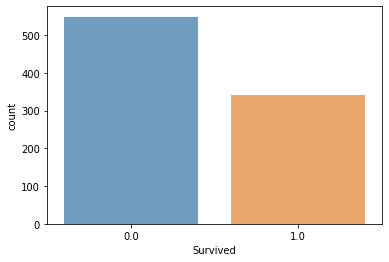

In [3]:
sns.countplot(x=df['Survived'], alpha=0.7, data=df)

### Plotting numeric features

Text(0.5, 0, 'Age')

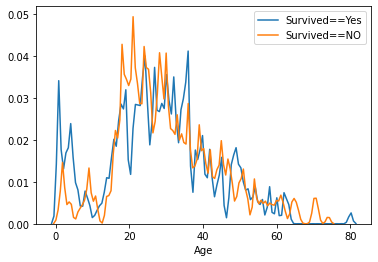

In [4]:
numerics = ['float','int']
df2 = df[df['Survived']==0].select_dtypes(include=numerics)
df3 = df[df['Survived']==1].select_dtypes(include=numerics)
sns.kdeplot(df3['Age'].values, bw=0.5,label='Survived==Yes')
sns.kdeplot(df2['Age'].values, bw=0.5,label='Survived==NO')
plt.xlabel('Age', fontsize=10)

Text(0.5, 0, 'Fare')

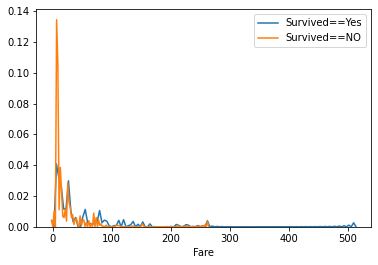

In [5]:
sns.kdeplot(df3['Fare'].values, bw=0.5,label='Survived==Yes')
sns.kdeplot(df2['Fare'].values, bw=0.5,label='Survived==NO')
plt.xlabel('Fare', fontsize=10)

### Plotting categorics features

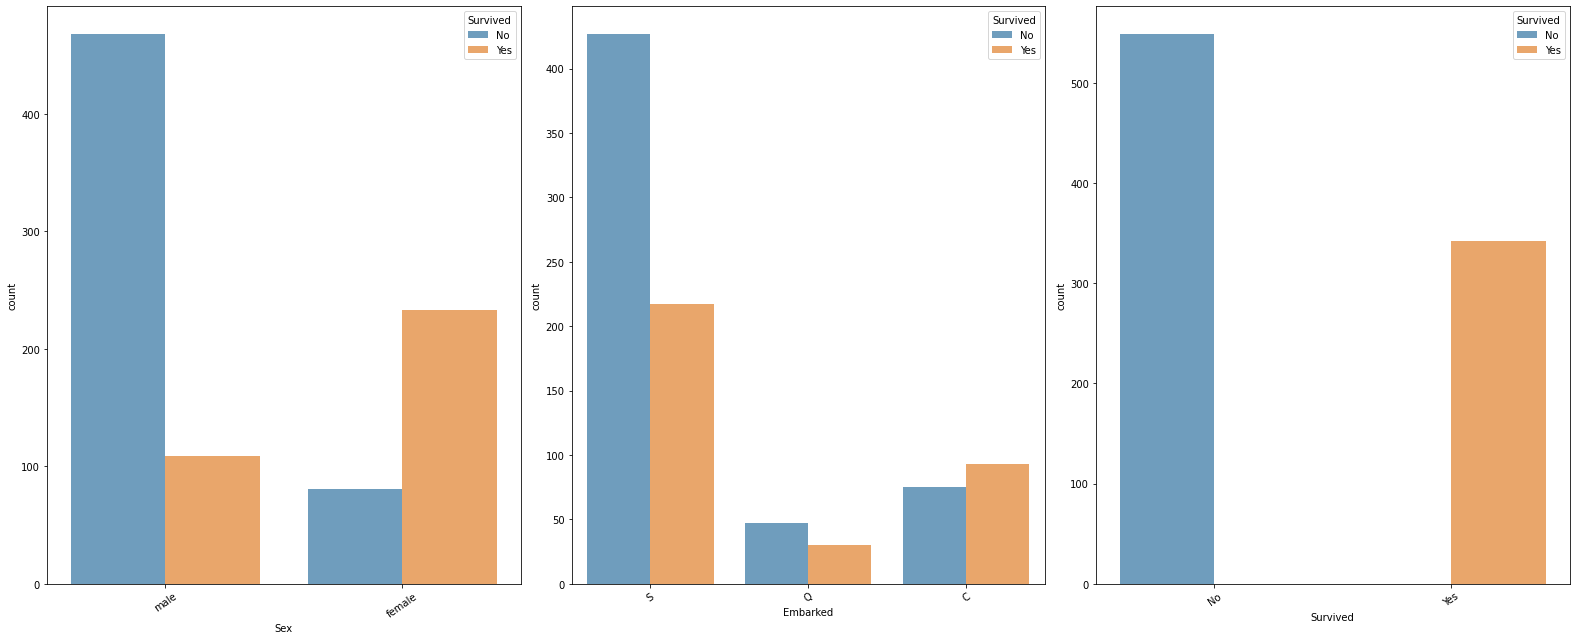

In [6]:
categorics = ['object']
c1 = df[df['Survived']==0].select_dtypes(include=categorics)
c1['Survived'] = 'No'
c2 = df[df['Survived']==1].select_dtypes(include=categorics)
c2['Survived'] = 'Yes'
c3 = pd.concat([c1,c2])
c3 = c3.drop(['Name','Cabin','Ticket'],axis=1)

fig, axes = plt.subplots(round(len(c3.columns) / 3), 3, figsize=(22, 9))

for i, ax in enumerate(fig.axes):
    if i < len(c3.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=35)
        sns.countplot(x=c3.columns[i], alpha=0.7, data=c3, ax=ax,hue="Survived")

fig.tight_layout()

### Data Preparation + Feature Enginnering

In [7]:
#Input median in null values
#Median age of Pclass, because its high correlation (-0,40)
print(df.corr()['Age'].sort_values(ascending=False))
df['Age'] = df.groupby("Pclass")['Age'].transform(lambda x: x.fillna(x.median()))

Age            1.000000
Fare           0.178740
PassengerId    0.028814
Survived      -0.077221
Parch         -0.150917
SibSp         -0.243699
Pclass        -0.408106
Name: Age, dtype: float64


In [8]:
#Input median in null values
#Median fare of Pclass, because its high correlation (-0,55)
print(df.corr()['Fare'].sort_values(ascending=False))
df['Fare'] = df.groupby("Pclass")['Fare'].transform(lambda x: x.fillna(x.median()))

Fare           1.000000
Survived       0.257307
Parch          0.221539
Age            0.202512
SibSp          0.160238
PassengerId    0.031428
Pclass        -0.558629
Name: Fare, dtype: float64


In [9]:
#input mode in null values
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)

#Define the size of family
df["Fsize"] = df["SibSp"] + df["Parch"] + 1
df['IsAlone'] = np.where(df["Fsize"]==1,1,0)

#Create a feature using age x pclass
df['Age_Class']= df['Age']* df['Pclass']

#Transform Age in groups
df['Age_cut'] = pd.qcut(df['Age'],5,duplicates='drop')

#Extract title of the string
df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr','Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')


# Insert0 in null values 
df['Title']= df['Title'].fillna(0)

#Create a null feature fare per person
df['Fare_Per_Person'] = df['Fare']/(df["Fsize"]+1)
df['Fare_Per_Person'] = df['Fare_Per_Person'].astype(int)

#Transform Fare in groups
df['Fare_cut'] =  pd.qcut(df['Fare'],5,duplicates='drop')

#Extract len of cabin
df['Cabin_len'] = df['Cabin'].astype(str).apply(lambda x : len(x))

#Extract the firstletter
df['Cabin'] = df['Cabin'].fillna("M") #filter Na and input M (missing)
df['Cabin'] = df['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())

#Ticktet
df['Ticket']=df.Ticket.apply(lambda x : len(x))


#Drop some colunms
df = df.drop(['Name'], axis = 1)

df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Fsize,IsAlone,Age_Class,Age_cut,Title,Fare_Per_Person,Fare_cut,Cabin_len
0,892,3,male,34.5,0,0,6,7.8292,M,Q,NaN,1,1,103.5,"(29.0, 39.0]",Mr,3,"(-0.001, 7.854]",3
1,893,3,female,47.0,1,0,6,7.0000,M,S,NaN,2,0,141.0,"(39.0, 80.0]",Mrs,2,"(-0.001, 7.854]",3
2,894,2,male,62.0,0,0,6,9.6875,M,Q,NaN,1,1,124.0,"(39.0, 80.0]",Mr,4,"(7.854, 10.5]",3
3,895,3,male,27.0,0,0,6,8.6625,M,S,NaN,1,1,81.0,"(24.0, 29.0]",Mr,4,"(7.854, 10.5]",3
4,896,3,female,22.0,1,1,7,12.2875,M,S,NaN,3,0,66.0,"(21.0, 24.0]",Mrs,3,"(10.5, 21.558]",3


In [10]:
scaler = preprocessing.StandardScaler().fit(df[['Age','Fare']])
df[['Age','Fare']] = scaler.transform(df[['Age','Fare']])                                          

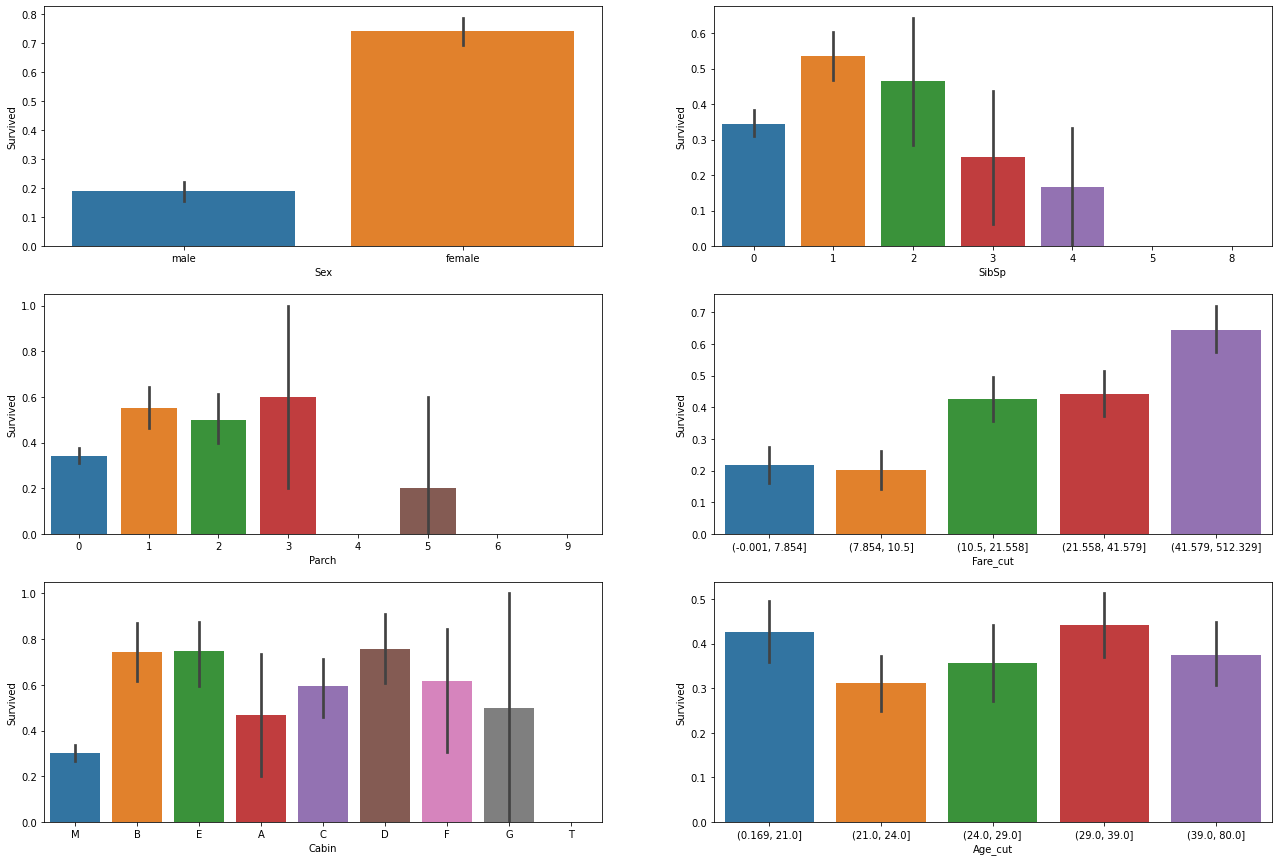

In [11]:
#graph individual features by survival
fig, saxis = plt.subplots(3, 2,figsize=(22,15))

sns.barplot(x = 'Sex', y = 'Survived', data=df, ax = saxis[0,0])
sns.barplot(x = 'SibSp', y = 'Survived',data=df, ax = saxis[0,1])
sns.barplot(x = 'Parch', y = 'Survived',  data=df, ax = saxis[1,0])
sns.barplot(x = 'Fare_cut', y = 'Survived', data=df, ax = saxis[1,1])
sns.barplot(x = 'Cabin', y = 'Survived', data=df, ax = saxis[2,0])
sns.barplot(x = 'Age_cut', y = 'Survived', data=df, ax = saxis[2,1])

In [12]:
#Transform categorics features in numeric

df['Age_cut'] =  LabelEncoder().fit_transform(df['Age_cut'])

df['Fare_cut'] =  LabelEncoder().fit_transform(df['Fare_cut'])


titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
df['Title']= df['Title'].map(titles)

groups = {"M": 1, "C": 2, "B": 3, "D": 4, "E": 5, "A": 6, "F": 7, "G": 8,'T':9}
df['Cabin'] = df['Cabin'].map(groups)

ports = {"S": 0, "C": 1, "Q": 2}
df['Embarked'] = df['Embarked'].map(ports)

#Transform sex in a dummies feature
df['Sex_female'] = np.where(df['Sex'] == 'female',1,0)

#Transform sex in a dummies feature
df['Sex_male'] = np.where(df['Sex'] == 'male',1,0)
df = df.drop(['Sex'],axis=1)

In [13]:
from category_encoders.one_hot import OneHotEncoder
dummies = OneHotEncoder(cols= ['Pclass','Age_cut','Fare_cut','Embarked','Title'],use_cat_names=True)
dummies.fit(df)
df = dummies.transform(df)

Collinear variables are those which are highly correlated with one another. These can decrease the model's availablility to learn, decrease model interpretability, and decrease generalization performance on the test set.

In [14]:

# Threshold for removing correlated variables
threshold = 0.8

# Absolute value correlation matrix
corr_matrix = df.corr().abs()
corr_matrix.head()

,PassengerId,Pclass_3.0,Pclass_2.0,Pclass_1.0,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Title_5.0,Fare_Per_Person,Fare_cut_0.0,Fare_cut_1.0,Fare_cut_2.0,Fare_cut_3.0,Fare_cut_4.0,Cabin_len,Sex_female,Sex_male
PassengerId,1.000000,0.041544,0.022714,0.026495,0.019113,0.055224,0.008942,0.001623,0.031029,0.016793,...,0.004011,0.035194,0.048268,0.055563,0.001128,0.014435,0.021562,0.030796,0.013406,0.013406
Pclass_3.0,0.041544,1.000000,0.563180,0.622172,0.382290,0.072610,0.019521,0.009189,0.419921,0.375052,...,0.163622,0.417220,0.421723,0.313118,0.027551,0.276761,0.435976,0.142243,0.116562,0.116562
Pclass_2.0,0.022714,0.563180,1.000000,0.296526,0.010619,0.052419,0.010057,0.130376,0.121168,0.078281,...,0.049092,0.108043,0.239634,0.084821,0.330757,0.199791,0.200972,0.099065,0.028862,0.028862
Pclass_1.0,0.026495,0.622172,0.296526,1.000000,0.431766,0.034256,0.013033,0.112900,0.600115,0.507627,...,0.142594,0.584558,0.260369,0.281522,0.281522,0.130578,0.694277,0.258250,0.107371,0.107371
Age,0.019113,0.382290,0.010619,0.431766,1.000000,0.198653,0.129467,0.035004,0.201170,0.200237,...,0.180134,0.229329,0.095718,0.080888,0.119782,0.062628,0.234201,0.074419,0.051876,0.051876


In [15]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,PassengerId,Pclass_3.0,Pclass_2.0,Pclass_1.0,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Title_5.0,Fare_Per_Person,Fare_cut_0.0,Fare_cut_1.0,Fare_cut_2.0,Fare_cut_3.0,Fare_cut_4.0,Cabin_len,Sex_female,Sex_male
PassengerId,NaN,0.041544,0.022714,0.026495,0.019113,0.055224,0.008942,0.001623,0.031029,0.016793,...,0.004011,0.035194,0.048268,0.055563,0.001128,0.014435,0.021562,0.030796,0.013406,0.013406
Pclass_3.0,NaN,NaN,0.563180,0.622172,0.382290,0.072610,0.019521,0.009189,0.419921,0.375052,...,0.163622,0.417220,0.421723,0.313118,0.027551,0.276761,0.435976,0.142243,0.116562,0.116562
Pclass_2.0,NaN,NaN,NaN,0.296526,0.010619,0.052419,0.010057,0.130376,0.121168,0.078281,...,0.049092,0.108043,0.239634,0.084821,0.330757,0.199791,0.200972,0.099065,0.028862,0.028862
Pclass_1.0,NaN,NaN,NaN,NaN,0.431766,0.034256,0.013033,0.112900,0.600115,0.507627,...,0.142594,0.584558,0.260369,0.281522,0.281522,0.130578,0.694277,0.258250,0.107371,0.107371
Age,NaN,NaN,NaN,NaN,NaN,0.198653,0.129467,0.035004,0.201170,0.200237,...,0.180134,0.229329,0.095718,0.080888,0.119782,0.062628,0.234201,0.074419,0.051876,0.051876


In [16]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))
dataset = df.drop(columns = to_drop)
print('Data shape: ', df.shape)
print('Size of the data', df.shape)

There are 4 columns to remove.
Data shape:  (1309, 36)
Size of the data (1309, 36)


### Create a final dataframe with all features

In [17]:
x_valid = df[df['Survived'].isna()].drop(['Survived'], axis = 1)
submission = x_valid['PassengerId'].to_frame()
#x_valid = x_valid.drop(['PassengerId'],axis = 1)

x1 = df[df['Survived']==0]  
x2 = df[df['Survived']==1]
x= pd.concat([x1,x2])

y =x.loc[:,['Survived','PassengerId']]
x =x.drop(['Survived','PassengerId'], axis = 1)

In [18]:
#Read DataFrame
teste = pd.read_csv("../input/testey/full-tita.csv",sep=";")
teste = teste.drop(['x'],axis=1)
teste

x_valid = x_valid.merge(teste)
x_valid = x_valid.drop(['Survived'],axis = 1)
y_valid = teste['Survived']
#df = pd.concat([test,train],sort=False)
#df.head()

###  Cross Validation

In [19]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

### Testing some Models to get the maximum accurancy ###
1) Logistic Regression 

2) Support vector Machine

3) Stochastic gradient descent

4) k nearest neighbors

5) Gaussian Naive Bayes

6) Random Forest

7) Bagging

8) Xgboost

9) Lgbm

10) Stacking with voting classifier

### 1) Logistic Regression

In [20]:
lr = LogisticRegression(class_weight = 'balanced', solver = 'liblinear',penalty="l2")
lr.fit(x,y['Survived'])
print(cross_val_score(lr, x, y['Survived'], cv=kf).mean())

0.8058000125541398


In [21]:
lr = LogisticRegression(class_weight = 'balanced', solver = 'liblinear',penalty="l1")
lr.fit(x,y['Survived'])
print(cross_val_score(lr, x_valid, y_valid, cv=kf).mean())

0.7748422260470453


### 2) SVM

In [22]:
svm = SVC(gamma='auto',random_state=42)
svm.fit(x,y['Survived'])
print(cross_val_score(svm, x, y['Survived'], cv=kf).mean())

0.736231247253782


In [23]:
svm = SVC(gamma='auto',random_state=42)
svm.fit(x,y['Survived'])
print(cross_val_score(svm, x_valid, y_valid, cv=kf).mean())

0.605192197360872


### 3) Stochastic gradient descent

In [24]:
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(x,y['Survived'])
print(cross_val_score(sgd, x, y['Survived'], cv=kf).mean())

0.7226790534178644


### 4) k nearest neighbors

In [25]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(x,y['Survived'])
print(cross_val_score(knn, x, y['Survived'], cv=kf).mean())

0.7384847153348817


In [26]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(x,y['Survived'])
print(cross_val_score(knn, x_valid, y_valid, cv=kf).mean())

0.5596959265633965


### 5) Gaussian Naive Bayes

In [27]:
gaussian = GaussianNB()
gaussian.fit(x,y['Survived'])
print(cross_val_score(gaussian, x, y['Survived'], cv=kf).mean())

0.7912434875400164


### 6) Random Forest

In [28]:
rf_with_standardScaler=make_pipeline(StandardScaler(),RandomForestClassifier())
rf_with_standardScaler.fit(x,y['Survived'])
print(cross_val_score(rf_with_standardScaler, x, y['Survived'], cv=kf).mean())

0.8282468143870441


In [29]:
rf_with_standardScaler=make_pipeline(StandardScaler(),RandomForestClassifier())
rf_with_standardScaler.fit(x,y['Survived'])
print(cross_val_score(rf_with_standardScaler, x_valid, y_valid, cv=kf).mean())

0.7582616179001722


In [30]:
rf=RandomForestClassifier(n_estimators=100, oob_score = True)
rf.fit(x,y['Survived'])
print(cross_val_score(rf, x, y['Survived'], cv=kf).mean())
parametros = pd.DataFrame({'feature':x.columns,'Parameters':np.round(rf.feature_importances_,3)})
parametros = parametros.sort_values('Parameters',ascending=False).set_index('feature')
parametros

0.823758709434436


,Parameters
feature,
Age_Class,0.107
Fare,0.103
Title_1.0,0.095
Age,0.084
Sex_male,0.083
Sex_female,0.067
Fare_Per_Person,0.063
Ticket,0.049
Fsize,0.039


In [31]:
rf=RandomForestClassifier(n_estimators=100)
rf.fit(x,y['Survived'])
print(cross_val_score(rf, x_valid, y_valid, cv=kf).mean())


0.7631382673551348


### 7) Bagging

In [32]:
bagging = BaggingClassifier(bootstrap=True,n_jobs = -1,n_estimators=100)
bagging.fit(x,y['Survived'])
print(cross_val_score(bagging, x, y['Survived'], cv=kf).mean())

0.8271294959512898


In [33]:
bagging = BaggingClassifier(bootstrap=True,n_jobs = -1,n_estimators=100)
bagging.fit(x,y['Survived'])
print(cross_val_score(bagging, x_valid, y_valid, cv=kf).mean())

0.7558519793459554


### 8) Xgboost

In [34]:
xgboost = xgb.XGBClassifier(objective ='reg:logistic'
                            , colsample_bytree = 0.7
                            , learning_rate = 0.01
                            ,max_depth = 6
                            , n_estimators = 100
                            ,random_state=42
                            ,max_features= 0.8
                          ,min_samples_leaf =0.5
                           ,min_child_weight= 3)
xgboost.fit(x,y['Survived'])
print(cross_val_score(xgboost, x, y['Survived'], cv=kf).mean())

0.8282468143870443


In [35]:
#121 - 79,66

xgboost = xgb.XGBClassifier(colsample_bytree = 0.8
                            , learning_rate = 0.05
                            ,max_depth = 6
                            , n_estimators = 100
                            ,random_state=42 
                           )
xgboost.fit(x,y['Survived'])
print(cross_val_score(xgboost, x_valid, y_valid, cv=kf).mean())

0.7581468732071143


### 9) LGBM

In [36]:
lgbm=lgb.LGBMClassifier()                          
lgbm.fit(x,y['Survived'])
print(cross_val_score(lgbm, x, y['Survived'], cv=kf).mean())

0.8248885820099179


In [37]:
lgbm=lgb.LGBMClassifier(colsample_bytree = 0.8
                            , learning_rate = 0.015
                            ,max_depth = 5
                            , n_estimators = 100
                            ,random_state=42 )                          
lgbm.fit(x,y['Survived'])
print(cross_val_score(lgbm, x_valid, y_valid, cv=kf).mean())

0.7845668387837063


### 10) Stacking (Logistic Regression + SVM + LGBM)

In [38]:
stacking = VotingClassifier(estimators=[
    ('lr',lr),('svm',svm),('rf', rf)], voting='hard')
stacking.fit(x,y['Survived'])
print(cross_val_score(stacking, x, y['Survived'], cv=kf).mean())

0.8192643274119641


In [39]:
stacking = VotingClassifier(estimators=[
    ('lr',rf),('svm',knn),('xgboost', xgboost)], voting='hard')
stacking.fit(x,y['Survived'])
print(cross_val_score(stacking, x_valid, y_valid, cv=kf).mean())

0.7534136546184739


### Submission
Choose the best models in this case Xgboost and try tuning hiper-parameters using gridsearch

### Xgboost with hiper-parameters tuning

In [40]:
parameters = {
              'max_features': [0.8, 0.9],
              'min_samples_leaf' :[0.5,0.9],
              'colsample_bytree' :[0.8,0.9],
              'learning_rate' : [0.01,0.1],
               'min_child_weight': [3,5,7],
              }

model2 = xgb.XGBClassifier(objective ='reg:logistic' ,random_state=42,n_estimators=100,max_depth = 6)
grid_search2 = GridSearchCV(model2, parameters, cv=5,n_jobs=-1)
grid_search2.fit(x,y['Survived'])

print(grid_search2.best_params_)
print(grid_search2.best_score_)

{'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_features': 0.8, 'min_child_weight': 3, 'min_samples_leaf': 0.5}
0.8428661100998054


### Plotting the feature importance using shap 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


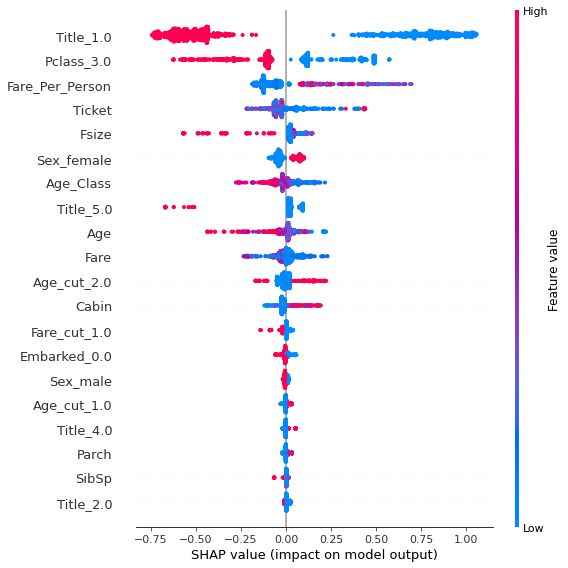

In [41]:
explainer = shap.TreeExplainer(grid_search2.best_estimator_)
shap_values = explainer.shap_values(x)
shap.summary_plot(shap_values, x)

### Drop features with low impact 

In [42]:
parametros = pd.DataFrame({'feature':x.columns,'Parameters':np.round(xgboost.feature_importances_,3)})
parametros = parametros.sort_values('Parameters',ascending=False).set_index('feature')
drop = list(parametros.tail(30).index)
print(drop)

x = x.drop(drop,axis=1)

x_valid = x_valid.drop(drop,axis=1)

['SibSp', 'Fsize', 'Title_4.0', 'Fare_Per_Person', 'Cabin', 'Fare', 'Pclass_2.0', 'Fare_cut_1.0', 'Age_cut_0.0', 'Age_Class', 'Age_cut_1.0', 'Ticket', 'Title_3.0', 'Fare_cut_0.0', 'Age_cut_3.0', 'Age', 'Title_2.0', 'Embarked_0.0', 'Pclass_1.0', 'Sex_male', 'Parch', 'Embarked_1.0', 'Embarked_2.0', 'Fare_cut_2.0', 'Cabin_len', 'IsAlone', 'Age_cut_2.0', 'Age_cut_4.0', 'Fare_cut_3.0', 'Fare_cut_4.0']


In [43]:
parameters = {
              'max_features': [0.7,0.8, 0.9],
              'min_samples_leaf' :[0.6,0.7,0.9],
              'colsample_bytree' :[0.6,0.8,0.9],
              'learning_rate' : [0.01,0.03,0.1],
               'min_child_weight': [3,5,7],
              }

model2 = xgb.XGBClassifier(objective ='reg:logistic' ,random_state=42,n_estimators=100,max_depth = 7)
grid_search2 = GridSearchCV(model2, parameters, cv=5,n_jobs=-1)
grid_search2.fit(x,y['Survived'])

print(grid_search2.best_params_)
print(grid_search2.best_score_)

{'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_features': 0.7, 'min_child_weight': 3, 'min_samples_leaf': 0.6}
0.8002008662356411


In [44]:
parameters = {
           'max_features': [0.7,0.8, 0.9],
              'min_samples_leaf' :[0.6,0.7,0.9],
              'colsample_bytree' :[0.6,0.8,0.9],
              'learning_rate' : [0.01,0.03,0.1],
               'min_child_weight': [3,5,7],
              }

model2 = xgb.XGBClassifier(objective ='reg:logistic' ,random_state=42,n_estimators=100,max_depth = 6)
grid_search2 = GridSearchCV(model2, parameters, cv=5,n_jobs=-1)
grid_search2.fit(x_valid,y_valid)

print(grid_search2.best_params_)
print(grid_search2.best_score_)

{'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_features': 0.7, 'min_child_weight': 7, 'min_samples_leaf': 0.6}
0.7753298909925416


In [45]:
svc=make_pipeline(StandardScaler(),SVC(random_state=1))
r=[0.0001,0.001,0.1,1,10,50,100]
PSVM=[{'svc__C':r, 'svc__kernel':['linear']},
      {'svc__C':r, 'svc__gamma':r, 'svc__kernel':['rbf']}]
GSSVM=GridSearchCV(estimator=svc, param_grid=PSVM, scoring='accuracy', cv=2)
scores_svm=cross_val_score(GSSVM, x_valid, y_valid,scoring='accuracy', cv=5)
np.mean(scores_svm)

0.777653471026965

### Make submission

In [46]:
Survived = grid_search2.best_estimator_.predict(x_valid)
submission['Survived'] = Survived  
submission['Survived'] = submission['Survived'].astype(int)
submission.to_csv('submission.csv' , index=False)